<a href="https://colab.research.google.com/github/setyoaji21/ensemble-feature-extraction-lung-cancer/blob/main/Feature_Extraction_with_Ensemble_Learning_Lung_Images_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount to GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Import Modules

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
import cv2
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

#Import Dataset

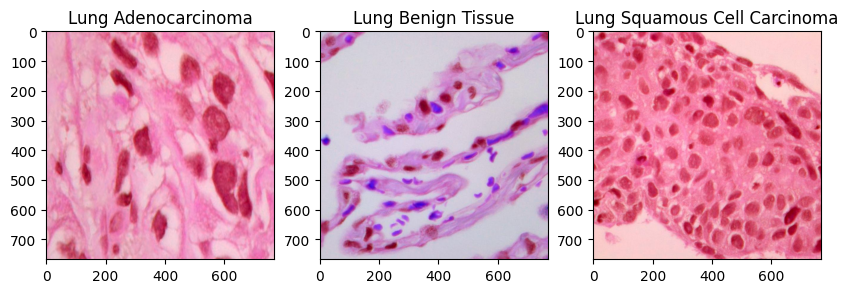

In [ ]:
lung_aca = "/content/gdrive/My Drive/Colab Notebooks/Final Assignment/lung_colon_image_set/lung_image_sets/lung_aca/"

plt.figure(figsize = (10, 10))
plt.subplot(131)
img = cv2.imread(lung_aca + os.listdir(lung_aca)[0])
plt.title('Lung Adenocarcinoma')
plt.imshow(img)

plt.subplot(132)
lung_n = "/content/gdrive/My Drive/Colab Notebooks/Final Assignment/lung_colon_image_set/lung_image_sets/lung_n/"
img = cv2.imread(lung_n + os.listdir(lung_n)[0])
plt.title('Lung Benign Tissue')
plt.imshow(img)

plt.subplot(133)
lung_scc = "/content/gdrive/My Drive/Colab Notebooks/Final Assignment/lung_colon_image_set/lung_image_sets/lung_scc/"
img = cv2.imread(lung_scc + os.listdir(lung_scc)[0])
plt.title('Lung Squamous Cell Carcinoma')
plt.imshow(img)
plt.show()

#Preprocessing and Split Data into Train and Validate

In [ ]:
data_dir = "/content/gdrive/My Drive/Colab Notebooks/Final Assignment/lung_colon_image_set/lung_image_sets/"
SIZE_X = SIZE_Y = 128

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.3)

train_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 12,
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)

validate_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 12,
                                       shuffle = False,
                                       subset='validation',
                                       seed = 42)

Found 10500 images belonging to 3 classes.
Found 4500 images belonging to 3 classes.


#Feature Extraction Helper

In [ ]:
def get_features(base_model, train, validate):
    X_train = base_model.predict(train)
    y_train = train.classes

    X_val = base_model.predict(validate)
    y_val = validate.classes

    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = True)
    print('Shape of X_train----->', str(X_train.shape))
    print('Shape of X_val----->', str(X_val.shape))
    print('Shape of X_test----->', str(X_test.shape))
    return (X_train, X_val, X_test, y_train, y_val, y_test)

#Model Helper

In [ ]:
def get_models():
    KNN = KNeighborsClassifier()

    SVM = SVC(kernel = 'linear')

    RF = RandomForestClassifier(n_estimators = 50)

    ADB = AdaBoostClassifier()

    XGB = XGBClassifier(n_estimators = 50, use_label_encoder=False)

    HardVoting = EnsembleVoteClassifier(clfs=[KNN, SVM, RF, ADB, XGB], voting='hard')

    SVM2 = SVC(kernel = 'linear', probability=True)
    SoftVoting = EnsembleVoteClassifier(clfs=[KNN, SVM2, RF, ADB, XGB], voting='soft')

    lr = LogisticRegression()
    Stacking = StackingClassifier(classifiers=[KNN, SVM, RF, ADB, XGB], meta_classifier=lr)

    # Grid search parameter untuk ensemble hard voting
    param_grid_hard_voting = {
        # Tidak perlu mengatur parameter khusus untuk hard voting, karena ini hanya mengambil mayoritas suara dari model base.
    }
    GridSearchHardVoting = GridSearchCV(estimator=HardVoting, param_grid=param_grid_hard_voting, cv=5)

    # Grid search parameter untuk ensemble soft voting
    param_grid_soft_voting = {
      'kneighborsclassifier__n_neighbors': [3, 5],  # Hyperparameter untuk KNN
      'svc__C': [0.1, 1],                      # Hyperparameter untuk SVM kedua (model kedua)
      'randomforestclassifier__n_estimators': [50],  # Hyperparameter untuk Random Forest
      'adaboostclassifier__n_estimators': [50],    # Hyperparameter untuk AdaBoost
      'xgbclassifier__max_depth': [3, 4],           # Hyperparameter untuk XGBoost
    }
    GridSearchSoftVoting = GridSearchCV(estimator=SoftVoting, param_grid=param_grid_soft_voting, cv=5, n_jobs=-1)

    param_grid_stacking = {
      'kneighborsclassifier__n_neighbors': [3, 5],  # Hyperparameter untuk KNN
      'svc__C': [0.1, 1],                      # Hyperparameter untuk SVM kedua (model kedua)
      'randomforestclassifier__n_estimators': [50],  # Hyperparameter untuk Random Forest
      'adaboostclassifier__n_estimators': [50],    # Hyperparameter untuk AdaBoost
      'xgbclassifier__max_depth': [3, 4],           # Hyperparameter untuk XGBoost
      'meta_classifier__C': [0.1, 1],
    }
    GridSearchStacking = GridSearchCV(estimator=Stacking, param_grid=param_grid_stacking, cv=5, n_jobs=-1)

    print("Defined------->")
    print("KNeighborsClassifier()")
    print("SVC(kernel = 'linear')")
    print("RandomForestClassifier(n_estimators = 50)")
    print("AdaBoostClassifier()")
    print("XGBClassifier(n_estimators = 50)")
    print("HardVoting")
    print("SoftVoting")
    print("Stacking")
    print("GridSearchHardVoting")
    print("GridSearchSoftVoting")
    print("GridSearchStacking")

    return (KNN, SVM, RF, ADB, XGB, HardVoting, SoftVoting, Stacking, GridSearchHardVoting, GridSearchSoftVoting, GridSearchStacking)

#Reshape Data Helper

In [ ]:
def reshape_data(X_train, X_val, X_test):
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    print("Shape after reshaping------->")
    print("X train------->", str(X_train.shape))
    print("X val-------->", str(X_val.shape))
    print("X test-------->", str(X_test.shape))

    return (X_train, X_val, X_test)

#Model and Accuracy Metrics Helper

In [ ]:
#Training Data Process
def fit_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def get_accuracy_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, model.predict(X_train))*100), "%")

    print("Val accuracy Score--------->")
    val_pred = model.predict(X_val)
    print("{0:.3f}".format(accuracy_score(y_val, val_pred)*100), "%")

    predicted =  model.predict(X_test)
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, predicted)*100), "%")

    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, predicted, average = 'weighted')*100), "%")

    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, predicted)*100), "%")

    print("Recall (Sensitivity)-------------->")
    print("{0:.3f}".format(recall_score(y_test, predicted, average = 'weighted')*100), "%")

    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, predicted, average = 'weighted')*100), "%")

    cf_matrix_test = confusion_matrix(y_test, predicted)

    print("=========================")
    print("Test Classification Report")
    print("=========================")
    print(classification_report(y_test, predicted, digits=4))
    print("=========================")

    res_test = []
    for t in [0,1,2]:
      prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==t,
                                                        np.array(predicted)==t,
                                                        pos_label=True,average=None)
      res_test.append([t,recall[0],recall[1]])

    pdRes = pd.DataFrame(res_test,columns = ['class','specificity','sensitivity'])
    display(pdRes)
    print("=========================")

    cf_matrix_val = confusion_matrix(y_val, val_pred)

    print("=========================")
    print("Val Classification Report")
    print("=========================")
    print(classification_report(y_val, val_pred, digits=4))
    print("=========================")

    res_val = []
    for v in [0,1,2]:
      prec,recall,_,_ = precision_recall_fscore_support(np.array(y_val)==v,
                                                        np.array(val_pred)==v,
                                                        pos_label=True,average=None)
      res_val.append([v,recall[0],recall[1]])

    pdRes = pd.DataFrame(res_test,columns = ['class','specificity','sensitivity'])
    display(pdRes)
    print("=========================")

    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")

    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")

    plt.show()

#KNN Algorithm Helper

In [ ]:
def fit_KNN_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    pca = PCA(n_components=7000)
    randlist = random.sample(range(0, X_train.shape[0]), 1000)
    if(X_train.shape[1] > 10000):
        X_train = pca.fit_transform(X_train)
        X_val = pca.transform(X_val)
        X_test = pca.transform(X_test)

    model.fit(X_train, y_train)
    get_accuracy_metrics(model, X_train[randlist, :], y_train[randlist], X_val, y_val, X_test, y_test)

#MobileNet Base Model

In [ ]:
base_model = MobileNet(include_top=False, input_shape=(SIZE_X, SIZE_Y, 3), weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 32)        288       
 )                                                               
                                                              

#Get Extracted Feature

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = get_features(model, train_it, validate_it)

375/375 [==============================] - 1952s 5s/step
Shape of X_train-----> (10500, 4, 4, 1024)
Shape of X_val-----> (2250, 4, 4, 1024)
Shape of X_test-----> (2250, 4, 4, 1024)


#Reshape Data

In [ ]:
X_train, X_val, X_test = reshape_data(X_train, X_val, X_test)

Shape after reshaping------->
X train-------> (10500, 16384)
X val--------> (2250, 16384)
X test--------> (2250, 16384)


#Scale Data

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#Get Models

In [ ]:
KNN, SVM, RF, ADB, XGB, HardVoting, SoftVoting, Stacking, GridSearchHardVoting, GridSearchSoftVoting, GridSearchStacking = get_models()

Defined------->
KNeighborsClassifier()
SVC(kernel = 'linear')
RandomForestClassifier(n_estimators = 50)
AdaBoostClassifier()
XGBClassifier(n_estimators = 50)
HardVoting
SoftVoting
Stacking
GridSearchHardVoting
GridSearchSoftVoting
GridSearchStacking


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


#KNN Result

Train accuracy Score------------>
90.000 %
Val accuracy Score--------->
87.422 %
Test accuracy Score--------->
85.022 %
F1 Score--------------->
84.843 %
Cohen Kappa Score------------->
77.558 %
Recall (Sensitivity)-------------->
85.022 %
Precision-------------->
86.224 %
Test Classification Report
              precision    recall  f1-score   support

           0     0.8586    0.6693    0.7522       762
           1     0.9889    0.9532    0.9707       748
           2     0.7380    0.9324    0.8239       740

    accuracy                         0.8502      2250
   macro avg     0.8618    0.8516    0.8489      2250
weighted avg     0.8622    0.8502    0.8484      2250



,class,specificity,sensitivity
0,0,0.943548,0.669291
1,1,0.994674,0.953209
2,2,0.837748,0.932432


Val Classification Report
              precision    recall  f1-score   support

           0     0.8879    0.7087    0.7882       738
           1     0.9903    0.9481    0.9687       752
           2     0.7768    0.9618    0.8595       760

    accuracy                         0.8742      2250
   macro avg     0.8850    0.8729    0.8722      2250
weighted avg     0.8846    0.8742    0.8726      2250



,class,specificity,sensitivity
0,0,0.943548,0.669291
1,1,0.994674,0.953209
2,2,0.837748,0.932432


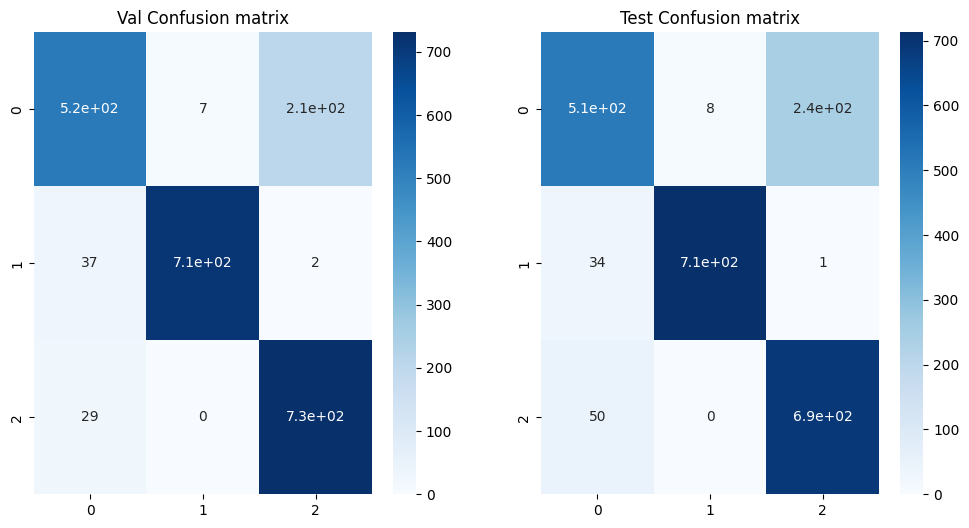

In [ ]:
fit_KNN_metrics(KNN, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

#SVM Result

Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
91.378 %
Test accuracy Score--------->
91.156 %
F1 Score--------------->
91.158 %
Cohen Kappa Score------------->
86.732 %
Recall (Sensitivity)-------------->
91.156 %
Precision-------------->
91.161 %
Test Classification Report
              precision    recall  f1-score   support

           0     0.8689    0.8701    0.8695       762
           1     0.9946    0.9933    0.9940       748
           2     0.8716    0.8716    0.8716       740

    accuracy                         0.9116      2250
   macro avg     0.9117    0.9117    0.9117      2250
weighted avg     0.9116    0.9116    0.9116      2250



,class,specificity,sensitivity
0,0,0.932796,0.870079
1,1,0.997337,0.993316
2,2,0.937086,0.871622


Val Classification Report
              precision    recall  f1-score   support

           0     0.8523    0.8916    0.8715       738
           1     0.9960    0.9934    0.9947       752
           2     0.8942    0.8566    0.8750       760

    accuracy                         0.9138      2250
   macro avg     0.9142    0.9138    0.9137      2250
weighted avg     0.9145    0.9138    0.9139      2250



,class,specificity,sensitivity
0,0,0.932796,0.870079
1,1,0.997337,0.993316
2,2,0.937086,0.871622


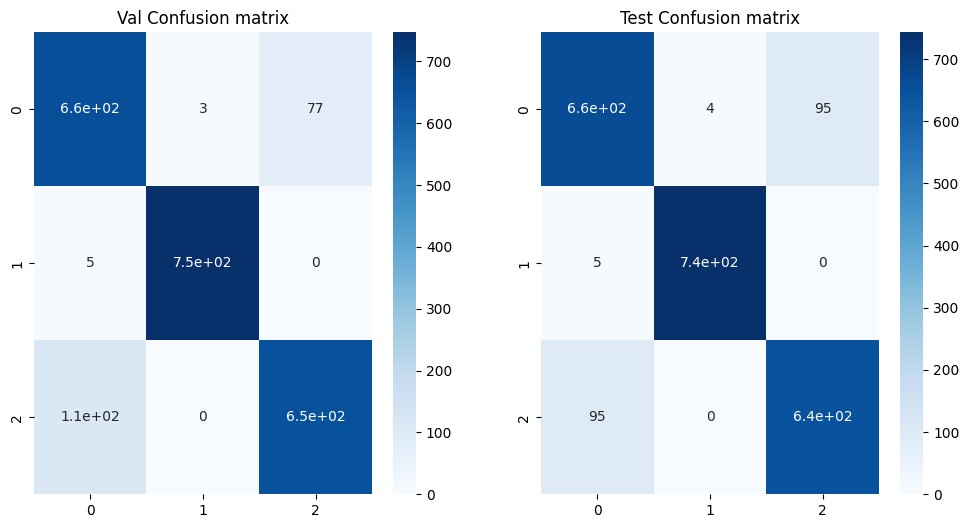

In [ ]:
SVM = fit_model(SVM, X_train_scaled, y_train)
get_accuracy_metrics(SVM, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

#RF Result

Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
90.400 %
Test accuracy Score--------->
89.067 %
F1 Score--------------->
89.130 %
Cohen Kappa Score------------->
83.594 %
Recall (Sensitivity)-------------->
89.067 %
Precision-------------->
89.295 %
Test Classification Report
              precision    recall  f1-score   support

           0     0.8170    0.8727    0.8439       762
           1     0.9904    0.9652    0.9777       748
           2     0.8727    0.8338    0.8528       740

    accuracy                         0.8907      2250
   macro avg     0.8934    0.8906    0.8915      2250
weighted avg     0.8929    0.8907    0.8913      2250



,class,specificity,sensitivity
0,0,0.899866,0.872703
1,1,0.995340,0.965241
2,2,0.940397,0.833784


Val Classification Report
              precision    recall  f1-score   support

           0     0.8279    0.8930    0.8592       738
           1     0.9931    0.9561    0.9743       752
           2     0.8986    0.8632    0.8805       760

    accuracy                         0.9040      2250
   macro avg     0.9065    0.9041    0.9047      2250
weighted avg     0.9070    0.9040    0.9049      2250



,class,specificity,sensitivity
0,0,0.899866,0.872703
1,1,0.995340,0.965241
2,2,0.940397,0.833784


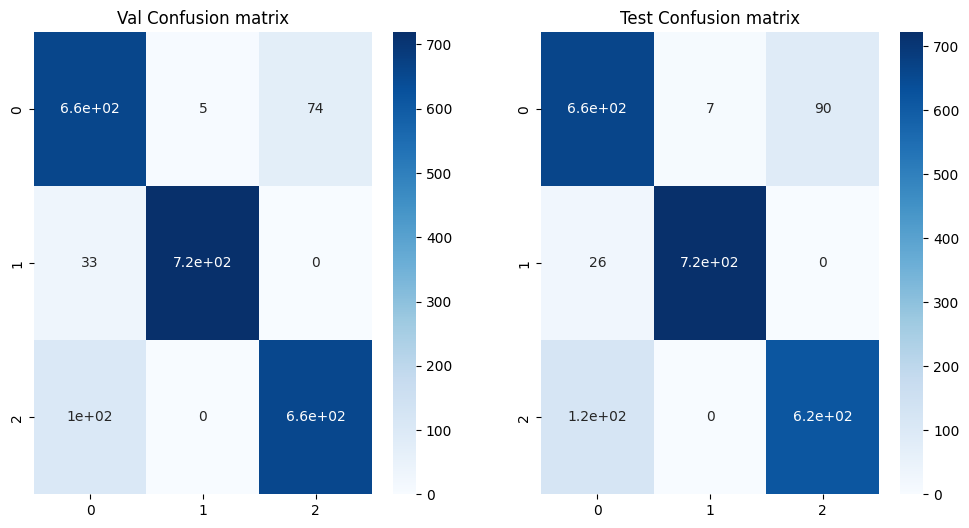

In [ ]:
RF = fit_model(RF, X_train_scaled, y_train)
get_accuracy_metrics(RF, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

#ADB Result

Train accuracy Score------------>
79.905 %
Val accuracy Score--------->
79.511 %
Test accuracy Score--------->
79.378 %
F1 Score--------------->
78.028 %
Cohen Kappa Score------------->
69.136 %
Recall (Sensitivity)-------------->
79.378 %
Precision-------------->
82.846 %
Test Classification Report
              precision    recall  f1-score   support

           0     0.8670    0.4619    0.6027       762
           1     0.9679    0.9679    0.9679       748
           2     0.6478    0.9595    0.7734       740

    accuracy                         0.7938      2250
   macro avg     0.8276    0.7964    0.7814      2250
weighted avg     0.8285    0.7938    0.7803      2250



,class,specificity,sensitivity
0,0,0.963710,0.461942
1,1,0.984021,0.967914
2,2,0.744371,0.959459


Val Classification Report
              precision    recall  f1-score   support

           0     0.8733    0.4390    0.5843       738
           1     0.9717    0.9601    0.9659       752
           2     0.6540    0.9776    0.7838       760

    accuracy                         0.7951      2250
   macro avg     0.8330    0.7923    0.7780      2250
weighted avg     0.8321    0.7951    0.7792      2250



,class,specificity,sensitivity
0,0,0.963710,0.461942
1,1,0.984021,0.967914
2,2,0.744371,0.959459


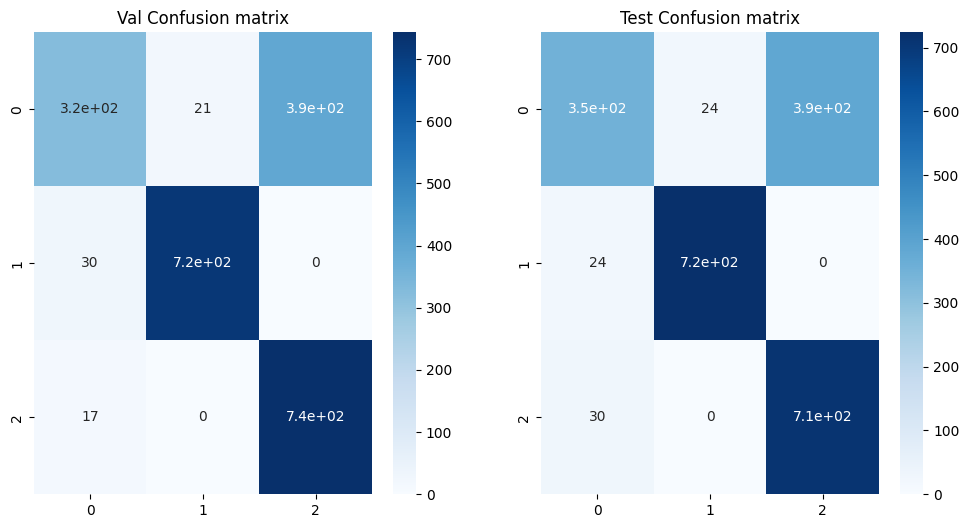

In [ ]:
ADB = fit_model(ADB, X_train_scaled, y_train)
get_accuracy_metrics(ADB, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

#XGB Result

Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
93.333 %
Test accuracy Score--------->
90.889 %
F1 Score--------------->
90.917 %
Cohen Kappa Score------------->
86.330 %
Recall (Sensitivity)-------------->
90.889 %
Precision-------------->
90.970 %
Test Classification Report
              precision    recall  f1-score   support

           0     0.8539    0.8819    0.8677       762
           1     0.9919    0.9786    0.9852       748
           2     0.8841    0.8662    0.8751       740

    accuracy                         0.9089      2250
   macro avg     0.9100    0.9089    0.9093      2250
weighted avg     0.9097    0.9089    0.9092      2250



,class,specificity,sensitivity
0,0,0.922715,0.881890
1,1,0.996005,0.978610
2,2,0.944371,0.866216


Val Classification Report
              precision    recall  f1-score   support

           0     0.8910    0.9079    0.8993       738
           1     0.9933    0.9827    0.9880       752
           2     0.9164    0.9092    0.9128       760

    accuracy                         0.9333      2250
   macro avg     0.9336    0.9333    0.9334      2250
weighted avg     0.9338    0.9333    0.9335      2250



,class,specificity,sensitivity
0,0,0.922715,0.881890
1,1,0.996005,0.978610
2,2,0.944371,0.866216


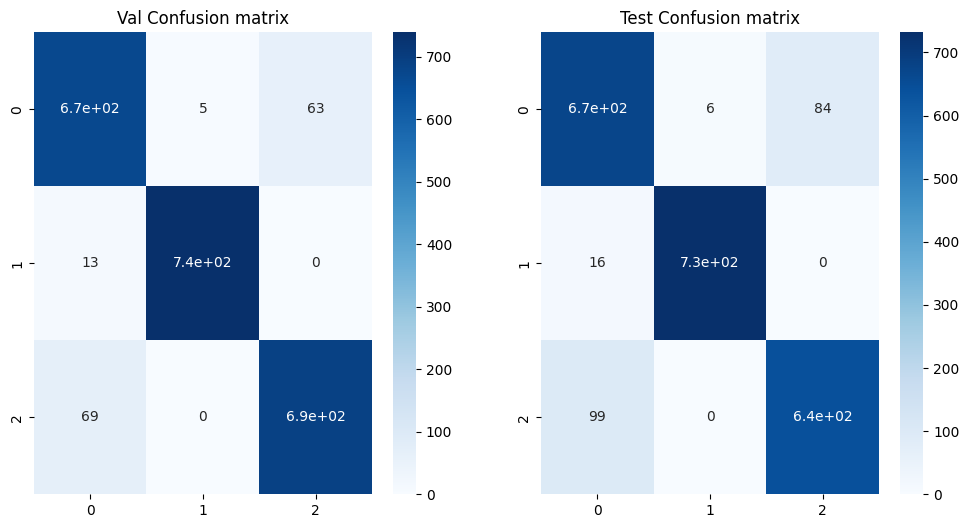

In [ ]:
XGB = fit_model(XGB, X_train_scaled, y_train)
get_accuracy_metrics(XGB, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

#Hard Voting Result

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
92.533 %
Test accuracy Score--------->
90.400 %
F1 Score--------------->
90.395 %
Cohen Kappa Score------------->
85.603 %
Recall (Sensitivity)-------------->
90.400 %
Precision-------------->
90.516 %
Test Classification Report
              precision    recall  f1-score   support

           0     0.8813    0.8281    0.8539       762
           1     0.9879    0.9786    0.9832       748
           2     0.8462    0.9068    0.8754       740

    accuracy                         0.9040      2250
   macro avg     0.9051    0.9045    0.9042      2250
weighted avg     0.9052    0.9040    0.9039      2250



,class,specificity,sensitivity
0,0,0.942876,0.828084
1,1,0.994008,0.978610
2,2,0.919205,0.906757


Val Classification Report
              precision    recall  f1-score   support

           0     0.9048    0.8631    0.8835       738
           1     0.9973    0.9801    0.9886       752
           2     0.8773    0.9316    0.9036       760

    accuracy                         0.9253      2250
   macro avg     0.9265    0.9249    0.9252      2250
weighted avg     0.9264    0.9253    0.9254      2250



,class,specificity,sensitivity
0,0,0.942876,0.828084
1,1,0.994008,0.978610
2,2,0.919205,0.906757


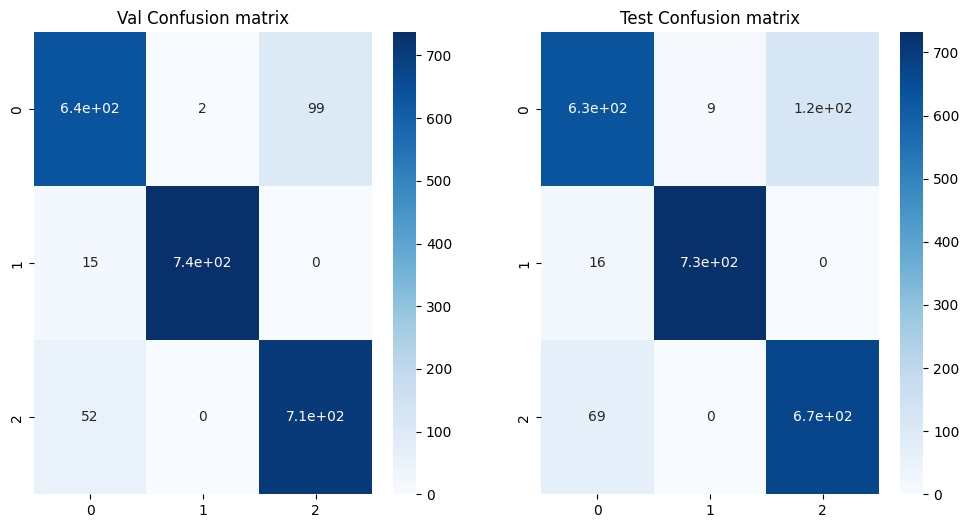

In [ ]:
HardVoting = fit_model(HardVoting, X_train_scaled, y_train)
get_accuracy_metrics(HardVoting, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

#Soft Voting Result

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
93.067 %
Test accuracy Score--------->
91.778 %
F1 Score--------------->
91.780 %
Cohen Kappa Score------------->
87.668 %
Recall (Sensitivity)-------------->
91.778 %
Precision-------------->
91.829 %
Test Classification Report
              precision    recall  f1-score   support

           0     0.8925    0.8609    0.8764       762
           1     0.9906    0.9840    0.9873       748
           2     0.8718    0.9095    0.8902       740

    accuracy                         0.9178      2250
   macro avg     0.9183    0.9181    0.9180      2250
weighted avg     0.9183    0.9178    0.9178      2250



,class,specificity,sensitivity
0,0,0.946909,0.860892
1,1,0.995340,0.983957
2,2,0.934437,0.909459


Val Classification Report
              precision    recall  f1-score   support

           0     0.8975    0.8902    0.8939       738
           1     0.9986    0.9801    0.9893       752
           2     0.8974    0.9211    0.9091       760

    accuracy                         0.9307      2250
   macro avg     0.9312    0.9304    0.9307      2250
weighted avg     0.9313    0.9307    0.9309      2250



,class,specificity,sensitivity
0,0,0.946909,0.860892
1,1,0.995340,0.983957
2,2,0.934437,0.909459


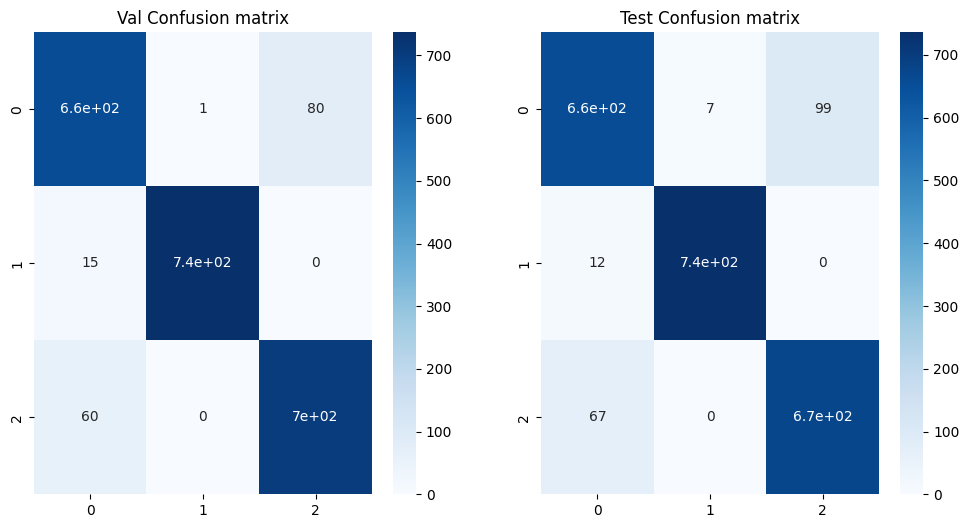

In [ ]:
SoftVoting = fit_model(SoftVoting, X_train_scaled, y_train)
get_accuracy_metrics(SoftVoting, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

#Stacking Result

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
86.756 %
Test accuracy Score--------->
84.844 %
F1 Score--------------->
84.834 %
Cohen Kappa Score------------->
77.267 %
Recall (Sensitivity)-------------->
84.844 %
Precision-------------->
86.631 %
Test Classification Report
              precision    recall  f1-score   support

           0     0.9130    0.7992    0.8523       762
           1     0.7500    0.9786    0.8492       748
           2     0.9357    0.7676    0.8434       740

    accuracy                         0.8484      2250
   macro avg     0.8663    0.8485    0.8483      2250
weighted avg     0.8663    0.8484    0.8483      2250



,class,specificity,sensitivity
0,0,0.961022,0.799213
1,1,0.837550,0.978610
2,2,0.974172,0.767568


Val Classification Report
              precision    recall  f1-score   support

           0     0.9213    0.8252    0.8706       738
           1     0.7724    0.9840    0.8655       752
           2     0.9556    0.7934    0.8670       760

    accuracy                         0.8676      2250
   macro avg     0.8831    0.8676    0.8677      2250
weighted avg     0.8832    0.8676    0.8677      2250



,class,specificity,sensitivity
0,0,0.961022,0.799213
1,1,0.837550,0.978610
2,2,0.974172,0.767568


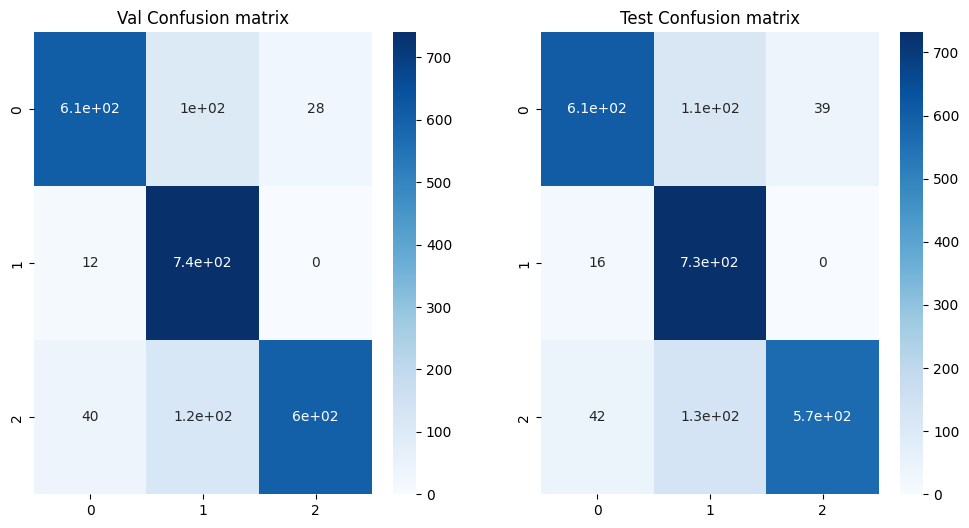

In [ ]:
Stacking = fit_model(Stacking, X_train_scaled, y_train)
get_accuracy_metrics(Stacking, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

#Grid Search Hard Voting Result

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarnin

Train accuracy Score------------>
99.990 %
Val accuracy Score--------->
92.711 %
Test accuracy Score--------->
90.222 %
F1 Score--------------->
90.226 %
Cohen Kappa Score------------->
85.336 %
Recall (Sensitivity)-------------->
90.222 %
Precision-------------->
90.333 %
Test Classification Report
              precision    recall  f1-score   support

           0     0.8753    0.8294    0.8518       762
           1     0.9892    0.9773    0.9832       748
           2     0.8454    0.9014    0.8725       740

    accuracy                         0.9022      2250
   macro avg     0.9033    0.9027    0.9025      2250
weighted avg     0.9033    0.9022    0.9023      2250



,class,specificity,sensitivity
0,0,0.939516,0.829396
1,1,0.994674,0.977273
2,2,0.919205,0.901351


Val Classification Report
              precision    recall  f1-score   support

           0     0.9065    0.8672    0.8864       738
           1     0.9959    0.9787    0.9873       752
           2     0.8820    0.9342    0.9073       760

    accuracy                         0.9271      2250
   macro avg     0.9281    0.9267    0.9270      2250
weighted avg     0.9281    0.9271    0.9272      2250



,class,specificity,sensitivity
0,0,0.939516,0.829396
1,1,0.994674,0.977273
2,2,0.919205,0.901351


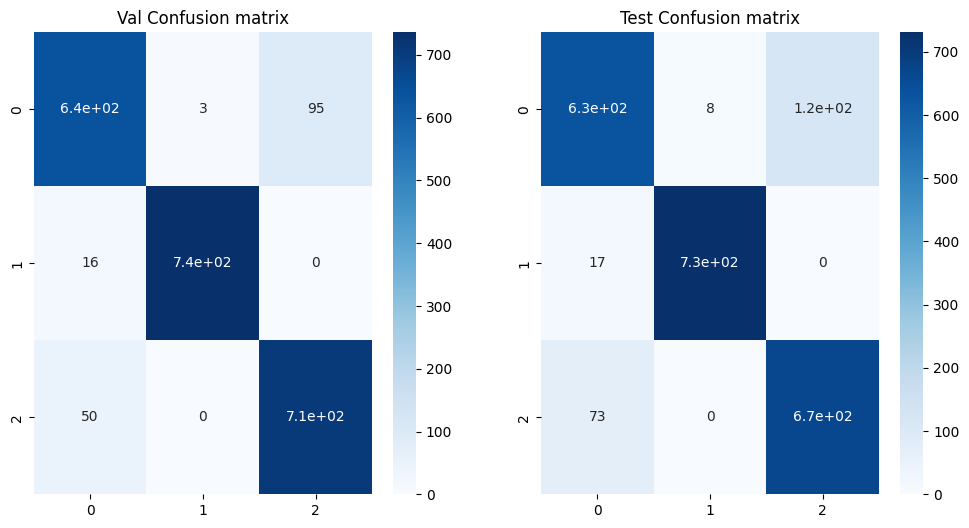

In [ ]:
GridSearchHardVoting = fit_model(GridSearchHardVoting, X_train_scaled, y_train)
get_accuracy_metrics(GridSearchHardVoting, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

#Grid Search Stacking Result

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Train accuracy Score------------>
99.914 %
Val accuracy Score--------->
87.956 %
Test accuracy Score--------->
86.622 %
F1 Score--------------->
86.538 %
Cohen Kappa Score------------->
79.934 %
Recall (Sensitivity)-------------->
86.622 %
Precision-------------->
87.446 %
Test Classification Report
              precision    recall  f1-score   support

           0     0.8997    0.8123    0.8538       762
           1     0.8009    0.9786    0.8809       748
           2     0.9228    0.8081    0.8617       740

    accuracy                         0.8662      2250
   macro avg     0.8745    0.8664    0.8654      2250
weighted avg     0.8745    0.8662    0.8654      2250



,class,specificity,sensitivity
0,0,0.953629,0.812336
1,1,0.878828,0.978610
2,2,0.966887,0.808108


Val Classification Report
              precision    recall  f1-score   support

           0     0.8978    0.8333    0.8644       738
           1     0.8135    0.9801    0.8890       752
           2     0.9514    0.8250    0.8837       760

    accuracy                         0.8796      2250
   macro avg     0.8876    0.8795    0.8790      2250
weighted avg     0.8877    0.8796    0.8791      2250



,class,specificity,sensitivity
0,0,0.953629,0.812336
1,1,0.878828,0.978610
2,2,0.966887,0.808108


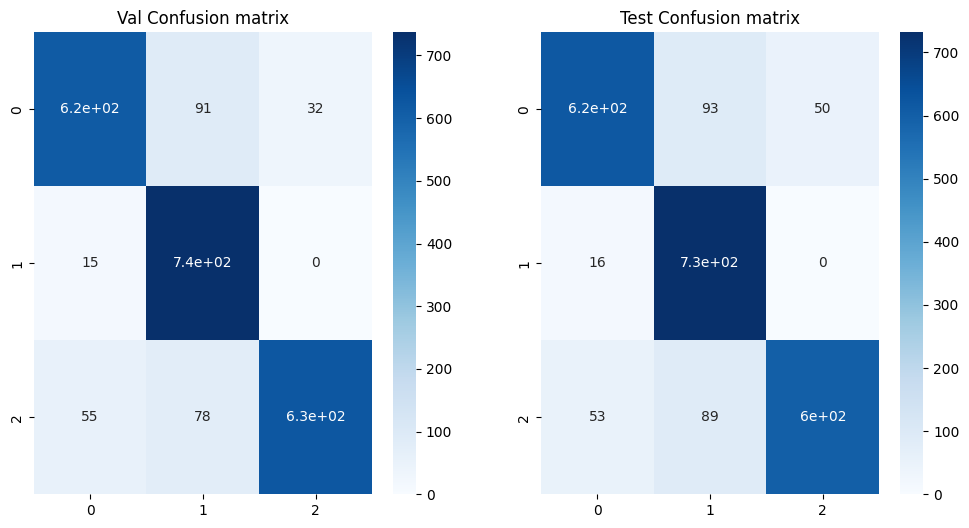

In [ ]:
GridSearchStacking = fit_model(GridSearchStacking, X_train_scaled, y_train)
get_accuracy_metrics(GridSearchStacking, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

#Grid Search Soft Voting Result

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Train accuracy Score------------>
99.981 %
Val accuracy Score--------->
93.378 %
Test accuracy Score--------->
91.378 %
F1 Score--------------->
91.378 %
Cohen Kappa Score------------->
87.069 %
Recall (Sensitivity)-------------->
91.378 %
Precision-------------->
91.485 %
Test Classification Report
              precision    recall  f1-score   support

           0     0.8944    0.8451    0.8691       762
           1     0.9933    0.9853    0.9893       748
           2     0.8566    0.9122    0.8835       740

    accuracy                         0.9138      2250
   macro avg     0.9148    0.9142    0.9140      2250
weighted avg     0.9148    0.9138    0.9138      2250



,class,specificity,sensitivity
0,0,0.948925,0.845144
1,1,0.996671,0.985294
2,2,0.925166,0.912162


Val Classification Report
              precision    recall  f1-score   support

           0     0.9096    0.8862    0.8977       738
           1     0.9960    0.9854    0.9906       752
           2     0.8971    0.9289    0.9127       760

    accuracy                         0.9338      2250
   macro avg     0.9342    0.9335    0.9337      2250
weighted avg     0.9342    0.9338    0.9339      2250



,class,specificity,sensitivity
0,0,0.948925,0.845144
1,1,0.996671,0.985294
2,2,0.925166,0.912162


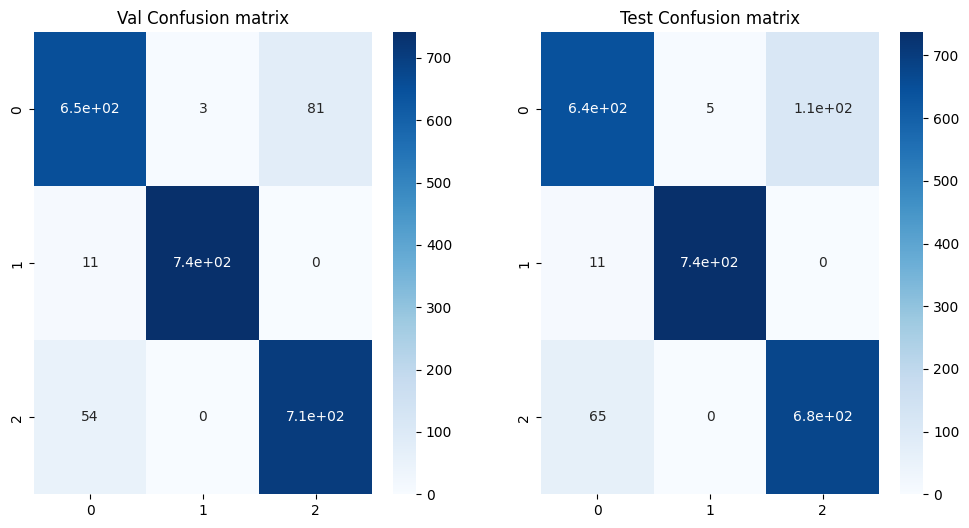

In [ ]:
GridSearchSoftVoting = fit_model(GridSearchSoftVoting, X_train_scaled, y_train)
get_accuracy_metrics(GridSearchSoftVoting, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)